# Generative Adversarial Network(GAN) 
![jupyter](https://miro.medium.com/max/1400/1*t78gwhhw-hn1CgXc1K89wA.png)

GAN is an unsupervised deep learning algorithm where we have a Generator pitted against an adversarial network called Discriminator.

Generator generates counterfeit currency. Discriminators are a team of cops trying to detect the counterfeit currency. Counterfeiters and cops both are trying to beat each other at their game.

Both Generator and Discriminator will be multi-layer perceptrons(MLP)

Generator’s objective will be to generate data that is very similar to the training data. Data generated from Generator should be indistinguishable from the real data.

Discriminator takes two sets of input, one input comes from the training dataset(real data) and the other input is the dataset generated by Generator.


Since self.discriminator.trainable = False is set after the discriminator is compiled, it will not affect the training of the discriminator. However since it is set before the combined model is compiled the discriminator layers will be frozen when the combined model is trained.

--come from https://machinelearningmastery.com/how-to-develop-a-generative-adversarial-network-for-a-1-dimensional-function-from-scratch-in-keras/

A generator model is capable of generating new artificial samples that plausibly could have come from an existing distribution of samples.

GANs includes a generator and a discriminator.
The generator is responsible for generating new samples from the domain, and the discriminator is responsible for classifying whether samples are real or fake (generated). 


The goal of this notebook:

 1. Developing a generative adversarial network from scratch for a simple one-dimensional function.
 2.  Developing separate discriminator and generator models, as well as a composite model for training the generator via the discriminator’s predictive behavior.
 3. Subjectively evaluating generated samples in the context of real examples from the problem domain.


To do this, we have six parts, i.e., 

 1. Select a One-Dimensional Function
 2. Define a Discriminator Model
 3. Define a Generator Model
 4. Training the Generator Model
 5. Evaluating the Performance of the GAN
 6. Complete Example of Training the GAN


### Part 1 Select a One-Dimensional Function, i.e., $y = x^2$

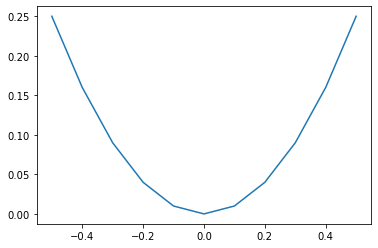

In [1]:
# demonstrate simple x^2 function
from matplotlib import pyplot

# simple function
def calculate(x):
	return x * x

# define inputs
inputs = [-0.5, -0.4, -0.3, -0.2, -0.1, 0, 0.1, 0.2, 0.3, 0.4, 0.5]
# calculate outputs
outputs = [calculate(x) for x in inputs]
# plot the result
pyplot.plot(inputs, outputs)
pyplot.show()

We can generate random samples  from the function
Based on the function $y = x^2$, we can generate a set of samples, by randomly generate $x \in [-0.5, 0.5]$ and then using this function to obtain the corresponding y. 


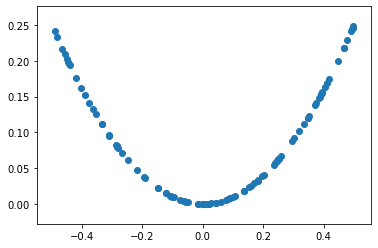

In [25]:
# example of generating random samples from X^2
from numpy.random import rand
from numpy import hstack
from matplotlib import pyplot

# generate randoms sample from x^2
def generate_samples(n=100):
	# generate random inputs in [-0.5, 0.5]
	X1 = rand(n) - 0.5
	# generate outputs X^2 (quadratic)
	X2 = X1 * X1
	# stack arrays
	X1 = X1.reshape(n, 1)
    
	X2 = X2.reshape(n, 1)
	return hstack((X1, X2))

# generate samples
data = generate_samples()
# plot samples
pyplot.scatter(data[:, 0], data[:, 1])
pyplot.show()

hstack() function is used to stack the sequence of input arrays horizontally (i.e. column wise) to make a single array.

![jupyter](https://www.w3resource.com/w3r_images/numpy-manipulation-hstack-function-image-a.png)

### Part 2 Define a Discriminator Model

The discriminator model is a binary classification problem.

    Inputs: Sample with two real values.
    Outputs: Binary classification, likelihood the sample is real (or fake).


In [27]:
# define the discriminator model
from keras.models import Sequential
from keras.layers import Dense
from keras.utils.vis_utils import plot_model

# define the standalone discriminator model
def define_discriminator(n_inputs=2):
	model = Sequential()
	model.add(Dense(25, activation='relu', kernel_initializer='he_uniform', input_dim=n_inputs))
	model.add(Dense(1, activation='sigmoid'))
	# compile model
	model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
	return model

# define the discriminator model
model = define_discriminator()
# summarize the model
model.summary()

# plot the model
#plot_model(model, to_file='discriminator_plot.png', show_shapes=True, show_layer_names=True)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 25)                75        
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 26        
Total params: 101
Trainable params: 101
Non-trainable params: 0
_________________________________________________________________


plot the model
plot_model(model, to_file='discriminator_plot.png', show_shapes=True, show_layer_names=True)

![jupyter](https://3qeqpr26caki16dnhd19sv6by6v-wpengine.netdna-ssl.com/wp-content/uploads/2019/04/Plot-of-the-Discriminator-Model-in-the-GAN.png)

generate_real_samples()  returns the output class labels for the real samples, specifically, an array of 1 values, where class=1 means real.

generate_fake_samples()  creats fake examples by generating random values of X in the range -1 and 1 for both elements of a sample. The output class label for all of these examples is 0.

 train_discriminator() function below implements this, training the model for 1,000 batches and using 128 samples per batch (64 fake and 64 real).

In [28]:
# define and fit a discriminator model
from numpy import zeros
from numpy import ones
from numpy import hstack
from numpy.random import rand
from numpy.random import randn
from keras.models import Sequential
from keras.layers import Dense

# define the standalone discriminator model
def define_discriminator(n_inputs=2):
	model = Sequential()
	model.add(Dense(25, activation='relu', kernel_initializer='he_uniform', input_dim=n_inputs))
	model.add(Dense(1, activation='sigmoid'))
	# compile model
	model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
	return model

# generate n real samples with class labels
def generate_real_samples(n):
	# generate inputs in [-0.5, 0.5]
	X1 = rand(n) - 0.5
	# generate outputs X^2
	X2 = X1 * X1
	# stack arrays
	X1 = X1.reshape(n, 1)
	X2 = X2.reshape(n, 1)
	X = hstack((X1, X2))
	# generate class labels
	y = ones((n, 1))
	return X, y

# generate n fake samples with class labels
def generate_fake_samples(n):
	# generate inputs in [-1, 1]
	X1 = -1 + rand(n) * 2
	# generate outputs in [-1, 1]
	X2 = -1 + rand(n) * 2
	# stack arrays
	X1 = X1.reshape(n, 1)
	X2 = X2.reshape(n, 1)
	X = hstack((X1, X2))
	# generate class labels
	y = zeros((n, 1))
	return X, y

# train the discriminator model
def train_discriminator(model, n_epochs=1000, n_batch=128):
	half_batch = int(n_batch / 2)
	# run epochs manually
	for i in range(n_epochs):
		# generate real examples
		X_real, y_real = generate_real_samples(half_batch)
		# update model
		model.train_on_batch(X_real, y_real)
		# generate fake examples
		X_fake, y_fake = generate_fake_samples(half_batch)
		# update model
		model.train_on_batch(X_fake, y_fake)
		# evaluate the model
		_, acc_real = model.evaluate(X_real, y_real, verbose=0)
		_, acc_fake = model.evaluate(X_fake, y_fake, verbose=0)
		print(i, acc_real, acc_fake)

# define the discriminator model
model = define_discriminator()
# fit the model
train_discriminator(model)

Instructions for updating:
Use tf.cast instead.
0 0.453125 0.28125
1 0.515625 0.234375
2 0.5625 0.34375
3 0.515625 0.265625
4 0.5625 0.1875
5 0.59375 0.21875
6 0.53125 0.328125
7 0.5 0.328125
8 0.5625 0.359375
9 0.375 0.453125
10 0.484375 0.390625
11 0.46875 0.421875
12 0.703125 0.3125
13 0.328125 0.34375
14 0.40625 0.453125
15 0.40625 0.390625
16 0.4375 0.421875
17 0.421875 0.4375
18 0.375 0.453125
19 0.5 0.53125
20 0.421875 0.484375
21 0.3125 0.453125
22 0.328125 0.515625
23 0.265625 0.53125
24 0.28125 0.515625
25 0.109375 0.578125
26 0.015625 0.625
27 0.03125 0.65625
28 0.0 0.640625
29 0.0 0.65625
30 0.046875 0.75
31 0.03125 0.78125
32 0.015625 0.65625
33 0.078125 0.71875
34 0.0 0.703125
35 0.03125 0.671875
36 0.03125 0.75
37 0.0625 0.734375
38 0.046875 0.78125
39 0.03125 0.71875
40 0.015625 0.6875
41 0.0625 0.6875
42 0.03125 0.828125
43 0.0625 0.703125
44 0.0 0.75
45 0.015625 0.703125
46 0.015625 0.6875
47 0.03125 0.71875
48 0.078125 0.578125
49 0.03125 0.8125
50 0.015625 0.6875
51

### The above results may vary but the model rapidly learns to correctly identify the real examples with perfect accuracy and is very good at identifying the fake examples with 80% to 90% accuracy.

**<font color = red>Question 1: Why does the classification performance of the classifiers increse with the increase of the epoachs?</font>** 

**<font color = red>Question 2: How about change the order:		_, acc_real = model.evaluate(X_real, y_real, verbose=0)
		_, acc_fake = model.evaluate(X_fake, y_fake, verbose=0)</font>** 

In [5]:
# define and fit a discriminator model
from numpy import zeros
from numpy import ones
from numpy import hstack
from numpy.random import rand
from numpy.random import randn
from keras.models import Sequential
from keras.layers import Dense

# define the standalone discriminator model
def define_discriminator(n_inputs=2):
	model = Sequential()
	model.add(Dense(25, activation='relu', kernel_initializer='he_uniform', input_dim=n_inputs))
	model.add(Dense(1, activation='sigmoid'))
	# compile model
	model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
	return model

# generate n real samples with class labels
def generate_real_samples(n):
	# generate inputs in [-0.5, 0.5]
	X1 = rand(n) - 0.5
	# generate outputs X^2
	X2 = X1 * X1
	# stack arrays
	X1 = X1.reshape(n, 1)
	X2 = X2.reshape(n, 1)
	X = hstack((X1, X2))
	# generate class labels
	y = ones((n, 1))
	return X, y

# generate n fake samples with class labels
def generate_fake_samples(n):
	# generate inputs in [-1, 1]
	X1 = -1 + rand(n) * 2
	# generate outputs in [-1, 1]
	X2 = -1 + rand(n) * 2
	# stack arrays
	X1 = X1.reshape(n, 1)
	X2 = X2.reshape(n, 1)
	X = hstack((X1, X2))
	# generate class labels
	y = zeros((n, 1))
	return X, y

# train the discriminator model
def train_discriminator(model, n_epochs=1000, n_batch=128):
    half_batch = int(n_batch / 2)
    # run epochs manually
    for i in range(n_epochs):
        # generate fake examples
        X_fake, y_fake = generate_fake_samples(half_batch)
        # update model
        model.train_on_batch(X_fake, y_fake)
        
        # generate real examples
        X_real, y_real = generate_real_samples(half_batch)
        # update model
        model.train_on_batch(X_real, y_real)       
        
        # evaluate the model
        _, acc_fake = model.evaluate(X_fake, y_fake, verbose=0)        
        _, acc_real = model.evaluate(X_real, y_real, verbose=0)
        print(i, acc_real, acc_fake)

# define the discriminator model
model = define_discriminator()
# fit the model
train_discriminator(model)

0 0.703125 0.40625
1 0.84375 0.265625
2 0.671875 0.40625
3 0.71875 0.390625
4 0.609375 0.4375
5 0.625 0.34375
6 0.5625 0.53125
7 0.703125 0.453125
8 0.640625 0.328125
9 0.546875 0.375
10 0.671875 0.421875
11 0.625 0.484375
12 0.546875 0.390625
13 0.609375 0.34375
14 0.53125 0.484375
15 0.5 0.375
16 0.578125 0.4375
17 0.578125 0.421875
18 0.578125 0.46875
19 0.4375 0.46875
20 0.59375 0.359375
21 0.453125 0.328125
22 0.53125 0.390625
23 0.515625 0.46875
24 0.453125 0.515625
25 0.421875 0.359375
26 0.40625 0.5
27 0.40625 0.5
28 0.4375 0.5
29 0.421875 0.421875
30 0.5 0.5
31 0.46875 0.4375
32 0.53125 0.53125
33 0.546875 0.46875
34 0.421875 0.453125
35 0.4375 0.453125
36 0.4375 0.5
37 0.484375 0.359375
38 0.5 0.40625
39 0.34375 0.421875
40 0.40625 0.46875
41 0.390625 0.40625
42 0.296875 0.484375
43 0.328125 0.390625
44 0.328125 0.4375
45 0.265625 0.53125
46 0.296875 0.375
47 0.40625 0.53125
48 0.3125 0.484375
49 0.40625 0.375
50 0.375 0.546875
51 0.359375 0.546875
52 0.328125 0.46875
53 0.29

### Part 3 Define a Generator Model
The generator model takes any point representing a sample as input  and output  $x$ and $x^2$.



- Inputs: Point in latent space, e.g. a five-element vector of Gaussian random numbers.
- Outputs: Two-element vector representing a generated sample for our function ($x$ and $x^2$).


The model takes as input a random five-element vector from the latent space and outputs a two-element vector for our one-dimensional function.

In [30]:
# define the generator model
from keras.models import Sequential
from keras.layers import Dense
from keras.utils.vis_utils import plot_model

# define the standalone generator model
def define_generator(latent_dim, n_outputs=2):
	model = Sequential()
	model.add(Dense(15, activation='relu', kernel_initializer='he_uniform', input_dim=latent_dim))
	model.add(Dense(n_outputs, activation='linear'))
	return model

# define the discriminator model
model = define_generator(5)
# summarize the model
model.summary()

# plot the model
#plot_model(model, to_file='generator_plot.png', show_shapes=True, show_layer_names=True)
#creating this plot assumes that the pydot and graphviz libraries are installed. 
#If this is a problem, you can comment out the import statement for the plot_model function and
#the call to the plot_model() function.

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 15)                90        
_________________________________________________________________
dense_10 (Dense)             (None, 2)                 32        
Total params: 122
Trainable params: 122
Non-trainable params: 0
_________________________________________________________________


![jupyter](https://3qeqpr26caki16dnhd19sv6by6v-wpengine.netdna-ssl.com/wp-content/uploads/2019/04/Plot-of-the-Generator-Model-in-the-GAN.png)

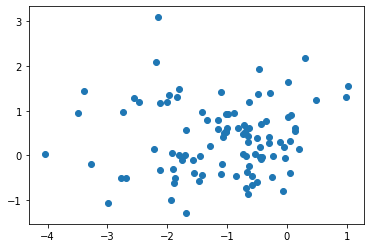

In [31]:
# define and use the generator model
from numpy.random import randn
from keras.models import Sequential
from keras.layers import Dense
from matplotlib import pyplot

# define the standalone generator model
def define_generator(latent_dim, n_outputs=2):
	model = Sequential()
	model.add(Dense(15, activation='relu', kernel_initializer='he_uniform', input_dim=latent_dim))
	model.add(Dense(n_outputs, activation='linear'))
	return model

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n):
	# generate points in the latent space
	x_input = randn(latent_dim * n)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n, latent_dim)
	return x_input

# use the generator to generate n fake examples and plot the results
def generate_fake_samples(generator, latent_dim, n):
	# generate points in latent space
	x_input = generate_latent_points(latent_dim, n)
	# predict outputs
	X = generator.predict(x_input)
	# plot the results
	pyplot.scatter(X[:, 0], X[:, 1])
	pyplot.show()

# size of the latent space
latent_dim = 5
# define the discriminator model
model = define_generator(latent_dim)
# generate and plot generated samples
generate_fake_samples(model, latent_dim, 100)

Running the example generates 100 random points from the latent space, uses this as input to the generator and generates 100 fake samples from our one-dimensional function domain.

As the generator has not been trained, the generated points are complete rubbish, as we expect, but we can imagine that as the model is trained, these points will slowly begin to resemble the target function and its u-shape.

In [33]:
# demonstrate creating the three models in the gan
from keras.models import Sequential
from keras.layers import Dense
from keras.utils.vis_utils import plot_model

# define the standalone discriminator model
def define_discriminator(n_inputs=2):
	model = Sequential()
	model.add(Dense(25, activation='relu', kernel_initializer='he_uniform', input_dim=n_inputs))
	model.add(Dense(1, activation='sigmoid'))
	# compile model
	model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
	return model

# define the standalone generator model
def define_generator(latent_dim, n_outputs=2):
	model = Sequential()
	model.add(Dense(15, activation='relu', kernel_initializer='he_uniform', input_dim=latent_dim))
	model.add(Dense(n_outputs, activation='linear'))
	return model

# define the combined generator and discriminator model, for updating the generator
def define_gan(generator, discriminator):
	# make weights in the discriminator not trainable.
    # In this model, the model weights of the discriminator model are not trainable 
    # and cannot be changed when the GAN model is updated via calls to train_on_batch().
	discriminator.trainable = False
	# connect them
	model = Sequential()
	# add generator
	model.add(generator)
	# add the discriminator
	model.add(discriminator)
	# compile model
	model.compile(loss='binary_crossentropy', optimizer='adam')
	return model

# size of the latent space
latent_dim = 5
# create the discriminator
discriminator = define_discriminator()
# create the generator
generator = define_generator(latent_dim)
# create the gan
gan_model = define_gan(generator, discriminator)
# summarize gan model
gan_model.summary()
# plot gan model
#plot_model(gan_model, to_file='gan_plot.png', show_shapes=True, show_layer_names=True)

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_11 (Sequential)   (None, 2)                 122       
_________________________________________________________________
sequential_10 (Sequential)   (None, 1)                 101       
Total params: 223
Trainable params: 122
Non-trainable params: 101
_________________________________________________________________


### Part 4 Training the generator model

<table align='left'>
<tr>
<td><img src='https://3qeqpr26caki16dnhd19sv6by6v-wpengine.netdna-ssl.com/wp-content/uploads/2019/04/Plot-of-the-Discriminator-Model-in-the-GAN.png'/></td>
<td><img src='https://3qeqpr26caki16dnhd19sv6by6v-wpengine.netdna-ssl.com/wp-content/uploads/2019/04/Plot-of-the-Generator-Model-in-the-GAN.png'/></td>
<td><img src='https://3qeqpr26caki16dnhd19sv6by6v-wpengine.netdna-ssl.com/wp-content/uploads/2019/04/Plot-of-the-Composite-Generator-and-Discriminator-Model-in-the-GAN.png'/></td>
</tr>
</table>

**<font color = red>Question 3: what is the difference for either the inputs or the outputs?</font>** 

**<font color = red>Question 4: how to combine them to design a GAN?</font>** 


### Obaservations to construct an GAN model

The weights in the generator model are updated based on the performance of the discriminator model.

- When the discriminator is good at detecting fake samples, the generator is updated more, and when the discriminator model is relatively poor or confused when detecting fake samples, the generator model is updated less.


The discriminator is concerned with distinguishing between real and fake examples, so it can be trained in an independent manner on examples of each, i.e., separately training for real samples and fake samples.
The generator model is concerned with the discriminator’s performance on fake examples, so all of the layers in the discriminator as not trainable when it is part of the GAN model so that the layers in the discriminator can not be updated and overtrained on fake examples.


The goal of the generator in the GAN model is to let the discriminator to regard the samples outputted by the generator as real samples, so generated samples of the generator in the GAN model is marked real (class 1).
However,  the goal of the discriminator in the GAN model would like to classify the generated samples as not real (class 0) or a low probability of being real (0.3 or 0.5). 
As a result, an error will be generated. Therefore, the backpropagation process used to update the model weights will update the model weights (i.e. only the weights in the generator) based on the error, in turn making the generator better at generating plausible fake samples.




- Inputs: Point in latent space, e.g. a five-element vector of Gaussian random numbers.
- Outputs: Binary classification, likelihood the sample is real (or fake).

The define_gan() function below takes as arguments the already-defined generator and discriminator models and creates the new logical third model subsuming these two models. The weights in the discriminator are marked as not trainable, which only affects the weights as seen by the GAN model and not the standalone discriminator model.


In [34]:
# train the composite model
def train_gan(gan_model, latent_dim, n_epochs=10000, n_batch=128):
	# manually enumerate epochs
	for i in range(n_epochs):
		# prepare points in latent space as input for the generator
		x_gan = generate_latent_points(latent_dim, n_batch)
		# create inverted labels for the fake samples
		y_gan = ones((n_batch, 1))
		# update the generator via the discriminator's error
		gan_model.train_on_batch(x_gan, y_gan)

the generate_latent_points() function in the previous section, and class=1 labels and calling the train_on_batch() function.

The train_gan() function below demonstrates this, although it is pretty uninteresting as only the generator will be updated each epoch, leaving the discriminator with default model weights


Instead, what is required is that we first update the discriminator model with real and fake samples, then update the generator via the composite model.

In [35]:
# train the generator and discriminator
def train(g_model, d_model, gan_model, latent_dim, n_epochs=10000, n_batch=128):
	# determine half the size of one batch, for updating the discriminator
	half_batch = int(n_batch / 2)
	# manually enumerate epochs
	for i in range(n_epochs):
		# prepare real samples
		x_real, y_real = generate_real_samples(half_batch)
		# prepare fake examples
		x_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
		# update discriminator
		d_model.train_on_batch(x_real, y_real)
		d_model.train_on_batch(x_fake, y_fake)
		# prepare points in latent space as input for the generator
		x_gan = generate_latent_points(latent_dim, n_batch)
		# create inverted labels for the fake samples
		y_gan = ones((n_batch, 1))
		# update the generator via the discriminator's error
		gan_model.train_on_batch(x_gan, y_gan)

### Part 5 Training the generator model

Generally, there are no objective ways to evaluate the performance of a GAN model.

In this specific case, we can devise an objective measure for the generated samples as we know the true underlying input domain and target function and can calculate an objective error measure.

Nevertheless, we will not calculate this objective error score in this tutorial. Instead, we will use the subjective approach used in most GAN applications. Specifically, we will use the generator to generate new samples and inspect them relative to real samples from the domain.

In [11]:
# evaluate the discriminator and plot real and fake points
def summarize_performance(epoch, generator, discriminator, latent_dim, n=100):
	# prepare real samples
	x_real, y_real = generate_real_samples(n)
	# evaluate discriminator on real examples
	_, acc_real = discriminator.evaluate(x_real, y_real, verbose=0)
	# prepare fake examples
	x_fake, y_fake = generate_fake_samples(generator, latent_dim, n)
	# evaluate discriminator on fake examples
	_, acc_fake = discriminator.evaluate(x_fake, y_fake, verbose=0)
	# summarize discriminator performance
	print(epoch, acc_real, acc_fake)
	# scatter plot real and fake data points
	pyplot.scatter(x_real[:, 0], x_real[:, 1], color='red')
	pyplot.scatter(x_fake[:, 0], x_fake[:, 1], color='blue')
	pyplot.show()

In [12]:
# train the generator and discriminator
def train(g_model, d_model, gan_model, latent_dim, n_epochs=10000, n_batch=128, n_eval=2000):
	# determine half the size of one batch, for updating the discriminator
	half_batch = int(n_batch / 2)
	# manually enumerate epochs
	for i in range(n_epochs):
		# prepare real samples
		x_real, y_real = generate_real_samples(half_batch)
		# prepare fake examples
		x_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
		# update discriminator
		d_model.train_on_batch(x_real, y_real)
		d_model.train_on_batch(x_fake, y_fake)
		# prepare points in latent space as input for the generator
		x_gan = generate_latent_points(latent_dim, n_batch)
		# create inverted labels for the fake samples
		y_gan = ones((n_batch, 1))
		# update the generator via the discriminator's error
		gan_model.train_on_batch(x_gan, y_gan)
		# evaluate the model every n_eval epochs
		if (i+1) % n_eval == 0:
			summarize_performance(i, g_model, d_model, latent_dim)

### Part 6 Complete Example of Training the GAN

C:\Users\xzhu2\Documents\ProgramData\anaconda3\envs\AML158736\lib\site-packages\keras\engine\training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1999 0.23000000417232513 1.0


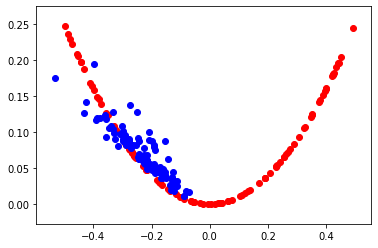

3999 0.6600000262260437 0.0


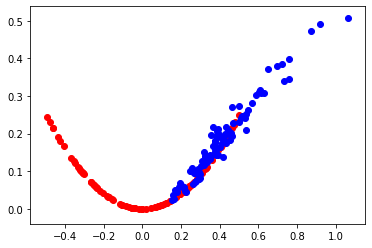

5999 0.4300000071525574 0.8399999737739563


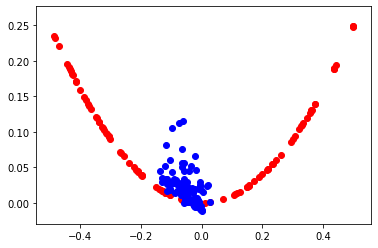

7999 0.6100000143051147 0.550000011920929


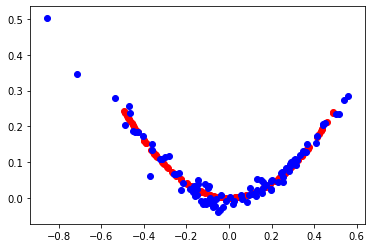

9999 0.6000000238418579 0.3799999952316284


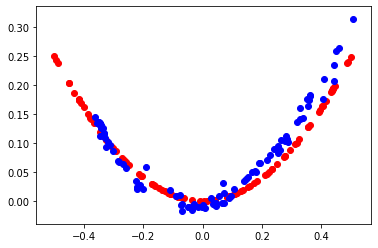

In [13]:
# train a generative adversarial network on a one-dimensional function
from numpy import hstack
from numpy import zeros
from numpy import ones
from numpy.random import rand
from numpy.random import randn
from keras.models import Sequential
from keras.layers import Dense
from matplotlib import pyplot

# define the standalone discriminator model
def define_discriminator(n_inputs=2):
	model = Sequential()
	model.add(Dense(25, activation='relu', kernel_initializer='he_uniform', input_dim=n_inputs))
	model.add(Dense(1, activation='sigmoid'))
	# compile model
	model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
	return model

# define the standalone generator model
def define_generator(latent_dim, n_outputs=2):
	model = Sequential()
	model.add(Dense(15, activation='relu', kernel_initializer='he_uniform', input_dim=latent_dim))
	model.add(Dense(n_outputs, activation='linear'))
	return model

# define the combined generator and discriminator model, for updating the generator
def define_gan(generator, discriminator):
	# make weights in the discriminator not trainable
	discriminator.trainable = False
	# connect them
	model = Sequential()
	# add generator
	model.add(generator)
	# add the discriminator
	model.add(discriminator)
	# compile model
	model.compile(loss='binary_crossentropy', optimizer='adam')
	return model

# generate n real samples with class labels
def generate_real_samples(n):
	# generate inputs in [-0.5, 0.5]
	X1 = rand(n) - 0.5
	# generate outputs X^2
	X2 = X1 * X1
	# stack arrays
	X1 = X1.reshape(n, 1)
	X2 = X2.reshape(n, 1)
	X = hstack((X1, X2))
	# generate class labels
	y = ones((n, 1))
	return X, y

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n):
	# generate points in the latent space
	x_input = randn(latent_dim * n)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n, latent_dim)
	return x_input

# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n):
	# generate points in latent space
	x_input = generate_latent_points(latent_dim, n)
	# predict outputs
	X = generator.predict(x_input)
	# create class labels
	y = zeros((n, 1))
	return X, y

# evaluate the discriminator and plot real and fake points
def summarize_performance(epoch, generator, discriminator, latent_dim, n=100):
	# prepare real samples
	x_real, y_real = generate_real_samples(n)
	# evaluate discriminator on real examples
	_, acc_real = discriminator.evaluate(x_real, y_real, verbose=0)
	# prepare fake examples
	x_fake, y_fake = generate_fake_samples(generator, latent_dim, n)
	# evaluate discriminator on fake examples
	_, acc_fake = discriminator.evaluate(x_fake, y_fake, verbose=0)
	# summarize discriminator performance
	print(epoch, acc_real, acc_fake)
	# scatter plot real and fake data points
	pyplot.scatter(x_real[:, 0], x_real[:, 1], color='red')
	pyplot.scatter(x_fake[:, 0], x_fake[:, 1], color='blue')
	pyplot.show()

# train the generator and discriminator
def train(g_model, d_model, gan_model, latent_dim, n_epochs=10000, n_batch=128, n_eval=2000):
	# determine half the size of one batch, for updating the discriminator
	half_batch = int(n_batch / 2)
	# manually enumerate epochs
	for i in range(n_epochs):
		# prepare real samples
		x_real, y_real = generate_real_samples(half_batch)
		# prepare fake examples
		x_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
		# update discriminator
		d_model.train_on_batch(x_real, y_real)
		d_model.train_on_batch(x_fake, y_fake)
		# prepare points in latent space as input for the generator
		x_gan = generate_latent_points(latent_dim, n_batch)
		# create inverted labels for the fake samples
		y_gan = ones((n_batch, 1))
		# update the generator via the discriminator's error
		gan_model.train_on_batch(x_gan, y_gan)
		# evaluate the model every n_eval epochs
		if (i+1) % n_eval == 0:
			summarize_performance(i, g_model, d_model, latent_dim)

# size of the latent space
latent_dim = 5
# create the discriminator
discriminator = define_discriminator()
# create the generator
generator = define_generator(latent_dim)
# create the gan
gan_model = define_gan(generator, discriminator)
# train model
train(generator, discriminator, gan_model, latent_dim)

## Discussion:

- Model Architecture. Experiment with alternate model architectures for the discriminator and generator, such as more or fewer nodes, layers, and alternate activation functions such as leaky ReLU.
- Data Scaling. Experiment with alternate activation functions such as the hyperbolic tangent (tanh) and any required scaling of training data.
- Alternate Target Function. Experiment with an alternate target function, such a simple sine wave, Gaussian distribution, a different quadratic, or even a multi-modal polynomial function.
